# Импорты, функции

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from regr_metrics_func import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
# from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Подготовка данных

In [2]:
X_train = pd.read_feather("../../0. Data/3. Saved_params/X_train.feather").to_numpy()
y_train = pd.read_feather("../../0. Data/3. Saved_params/Y_train.feather")
X_test  = pd.read_feather("../../0. Data/3. Saved_params/X_test.feather").to_numpy()
y_test  = pd.read_feather("../../0. Data/3. Saved_params/Y_test.feather")

In [ ]:
# data = pd.read_feather("../../0. Data/wide_data.feather")

# X = data.loc[:, ~data.columns.isin(["HL_1", "HL_2", "HL_3", "HL_4", "HL_5", "HL_6", "id"])]
# y = data.loc[:, "HL_1":"HL_6"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=242)

# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [86]:
y_bool = pd.read_feather("../0. Data/Y_bool.feather")

y_b_train, y_b_test = train_test_split(y_bool, test_size=0.2, random_state=42)

In [3]:
def check_MO_regression(model_obj, model_name=""):
    MO_regr = {' Stack': MultiOutputRegressor, ' Chain': RegressorChain}
    for name, model in MO_regr.items():
        y_pred = model(model_obj).fit(X_train, y_train).predict(X_test)
        print_model_res(y_pred, y_test, model_name, name, 3)
    return(None)


def plot_nn_losses(hist):
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return(None)

# Регрессионные модели
## Обычные регрессоры, поддерживающие MultiOutput по умолчанию

In [21]:
linear = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=500).fit(X_train, y_train)
etr = ExtraTreesRegressor().fit(X_train, y_train)
knn = KNeighborsRegressor().fit(X_train, y_train)

print_model_res(y_test, linear.predict(X_test), "Linear")
print_model_res(y_test, etr.predict(X_test), "ExtraTree")
print_model_res(y_test, rf.predict(X_test), "Random Forest")
print_model_res(y_test, knn.predict(X_test), "kNN")

Linear. RMSE: 2.155. C-index: 10.688
ExtraTree. RMSE: 2.092. C-index: 10.575
Random Forest. RMSE: 2.069. C-index: 10.55
kNN. RMSE: 2.289. C-index: 9.238


### Бустинги

In [22]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
warnings.filterwarnings("ignore", category=UserWarning)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 143,
    'alpha': 0.0, # 1e-3
    'lambda': 1 # 1e-4  
}

lgb_params = {
    'metric': 'rmse',
    'learning_rate': 0.05,
    'seed': 42,
    'verbose': -1
}

lgb_model = MultiOutputRegressor(lgb.LGBMRegressor(**lgb_params)).fit(X_train, y_train)
xgbst = xgb.train(xgb_params, xgb.DMatrix(X_train, label=y_train), 15)
ctb = CatBoostRegressor(iterations=100, random_seed=42, loss_function='MultiRMSE', verbose=0).fit(X_train, y_train)

print_model_res(y_test, lgb_model.predict(X_test), "LightGBM")
print_model_res(y_test, xgbst.predict(xgb.DMatrix(X_test, label=y_test)), "XGBoost")
print_model_res(y_test, ctb.predict(X_test), "CatBoost")

LightGBM. RMSE: 2.156. C-index: 10.662
XGBoost. RMSE: 2.147. C-index: 10.388
CatBoost. RMSE: 2.13. C-index: 10.325


## MultiOutputRegressor и RegressorChain

In [14]:
check_MO_regression(RandomForestRegressor(n_estimators=500, random_state=42), "Random Forest")

Random Forest Stack. RMSE: 2.07. C-index: 10.7
Random Forest Chain. RMSE: 2.044. C-index: 10.925


In [15]:
check_MO_regression(LinearRegression(), "Linear")

Linear Stack. RMSE: 2.155. C-index: 10.688
Linear Chain. RMSE: 2.155. C-index: 10.688


In [16]:
check_MO_regression(SVR(kernel='linear'), "SVR linear")
check_MO_regression(SVR(kernel='poly'), "SVR poly")
check_MO_regression(SVR(kernel='rbf'), "SVR rbf")

SVR linear Stack. RMSE: 2.303. C-index: 10.612
SVR linear Chain. RMSE: 2.249. C-index: 10.325
SVR poly Stack. RMSE: 2.141. C-index: 10.338
SVR poly Chain. RMSE: 2.144. C-index: 9.65
SVR rbf Stack. RMSE: 2.085. C-index: 10.962
SVR rbf Chain. RMSE: 2.062. C-index: 10.738


In [10]:
check_MO_regression(KNeighborsRegressor(n_neighbors=10), "kNN, k = 10")
check_MO_regression(KNeighborsRegressor(n_neighbors=15), "kNN, k = 15")
check_MO_regression(KNeighborsRegressor(n_neighbors=20), "kNN, k = 20")

kNN, k = 10 Stack. RMSE: 2.028. C-index: 9.412
kNN, k = 10 Chain. RMSE: 2.06. C-index: 9.426
kNN, k = 15 Stack. RMSE: 2.008. C-index: 8.956
kNN, k = 15 Chain. RMSE: 2.038. C-index: 9.118
kNN, k = 20 Stack. RMSE: 1.985. C-index: 9.279
kNN, k = 20 Chain. RMSE: 1.985. C-index: 9.029


## Нейронные сети

### tensorflow
Работает только под env. Под base запускать torch

In [4]:
import tensorflow as tf # type: ignore
from tensorflow.keras import layers, models, callbacks, regularizers # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore

In [5]:
tf_model = Sequential([
    Dense(128, input_dim=55, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(6)
])

tf_model.compile(optimizer='adam', loss='mse')
    
history = tf_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

y_pred = tf_model.predict(X_test)
print_model_res(y_test, y_pred, "Simple NN")

Simple NN. RMSE: 2.416. C-index: 9.225


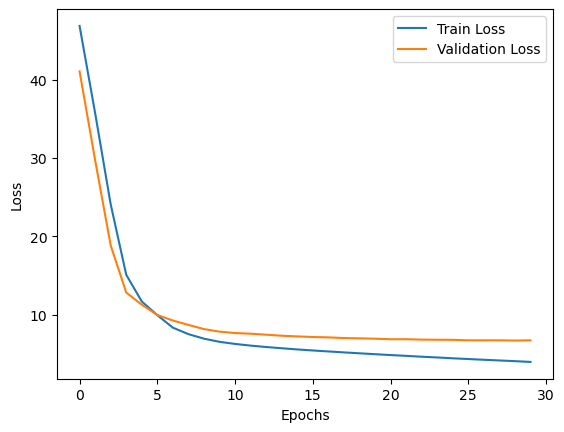

In [ ]:
plot_nn_losses(history)

Более сложная модель с промежуточными слоями

In [6]:
def create_model():
    model = models.Sequential([
        layers.Input(shape=(55,)),  # Входной слой для 55 признаков
        
        # Нормализация входных данных
        layers.experimental.preprocessing.Normalization(axis=-1),
        
        # Скрытые слои с регуляризацией
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Выходной слой с 6 нейронами (для 6 целевых признаков)
        layers.Dense(6)
    ])
    
    return model

In [7]:
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Используем MSE как функцию потерь
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Оценка модели
y_pred = model.predict(X_test)
print_model_res(y_test, y_pred, "A bit more complicated NN")

A bit more complicated NN. RMSE: 2.144. C-index: 10.275


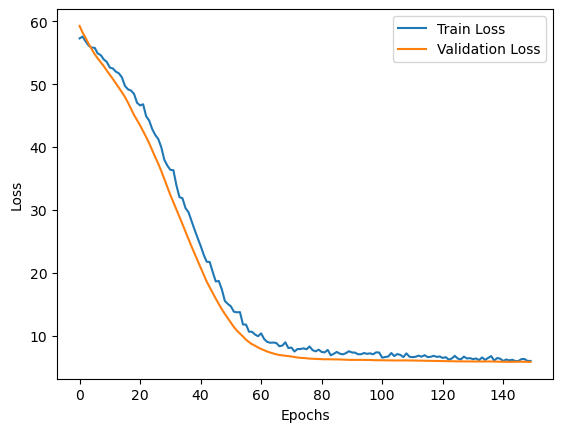

In [8]:
plot_nn_losses(history)

### PyTorch

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, DataLoader

In [25]:
n_round = 30

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(55, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 6)
        )
    
    def forward(self, x):
        return self.layers(x)

# Инициализация модели, функции потерь и оптимизатора
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Разделение на тренировочные и валидационные данные
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

# Создание DataLoader
train_dataset = TensorDataset(X_train_sub, y_train_sub)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Обучение модели
for epoch in range(n_round):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # Валидация
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
        val_loss /= len(val_loader)

# Предсказание на тестовых данных
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()


print_model_res(y_test, y_pred, "PyTorch MLP")

PyTorch MLP. RMSE: 2.442. C-index: 10.462


In [26]:
n_round = 200

# Предварительный расчет параметров нормализации
X_train_mean = torch.mean(torch.tensor(X_train, dtype=torch.float32), dim=0)
X_train_std = torch.std(torch.tensor(X_train, dtype=torch.float32), dim=0)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = nn.Parameter(mean, requires_grad=False)
        self.std = nn.Parameter(std, requires_grad=False)
        
    def forward(self, x):
        return (x - self.mean) / self.std

class Net(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.normalize = Normalization(mean, std)
        
        self.dense1 = nn.Linear(55, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.3)
        
        self.dense2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.3)
        
        self.dense3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.drop3 = nn.Dropout(0.3)
        
        self.dense_out = nn.Linear(32, 6)

    def forward(self, x):
        x = self.normalize(x)
        
        x = self.dense1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.drop1(x)
        
        x = self.dense2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.drop2(x)
        
        x = self.dense3(x)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.drop3(x)
        
        return self.dense_out(x)

# Инициализация модели
model = Net(X_train_mean, X_train_std)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Подготовка данных
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Обучение модели
for epoch in range(n_round):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Основная функция потерь
        loss = criterion(outputs, targets)
        
        # Регуляризация
        # Для первого слоя: L1(1e-5) + L2(1e-4)
        l1_reg = 1e-5 * torch.norm(model.dense1.weight, p=1)
        l2_reg = 1e-4 * torch.norm(model.dense1.weight, p=2)
        
        # Для остальных слоев: L2(0.01)
        l2_reg += 0.01 * torch.norm(model.dense2.weight, p=2)
        l2_reg += 0.01 * torch.norm(model.dense3.weight, p=2)
        
        # Общая функция потерь
        total_loss = loss + l1_reg + l2_reg
        
        total_loss.backward()
        optimizer.step()

# Предсказание и оценка
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

print_model_res(y_test, y_pred, "PyTorch NN (alt: +BatchNorm +DropOut +l1_l2_reg)")

PyTorch NN (alt: +BatchNorm +DropOut +l1_l2_reg). RMSE: 2.143. C-index: 10.188


In [27]:
n_round = 200

class PsychometricNet(nn.Module):
    def __init__(self, input_dim=55, output_dim=6):
        super(PsychometricNet, self).__init__()
        
        self.input_norm = nn.BatchNorm1d(input_dim)
        
        # Слой 1: полносвязный, BatchNorm, Dropout
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        # Слой 2: полносвязный, BatchNorm, Dropout
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        # Слой 3: полносвязный, BatchNorm, Dropout
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.3)
        
        # Выходной слой: 6 нейронов
        self.fc4 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        # Нормализация входа
        x = self.input_norm(x)
        
        # Слой 1
        x = nn.functional.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        # Слой 2
        x = nn.functional.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        
        # Слой 3
        x = nn.functional.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        
        # Выходной слой
        x = self.fc4(x)
        return x


# Преобразование NumPy массивов в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создаём TensorDataset и DataLoader для обучения и теста
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Создаём модель
model = PsychometricNet(input_dim=55, output_dim=6)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # weight_decay отвечает за L2-регуляризацию

# Обучаем модель
for epoch in range(n_round):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()


model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

print_model_res(y_test, predictions, "PyTorch NN (+BatchNorm +Dropout +l1_l2_reg)")

PyTorch NN (+BatchNorm +Dropout +l1_l2_reg). RMSE: 2.129. C-index: 10.05


## TabPFN

In [29]:
from tabpfn import TabPFNRegressor

# tab_model = RegressorChain(TabPFNRegressor()).fit(X_train, y_train)
tab_model = MultiOutputRegressor(TabPFNRegressor()).fit(X_train, y_train)

y_tabpfn_pred = tab_model.predict(X_test)
print_model_res(y_test, y_tabpfn_pred, "TabPFN")

d:\Programs\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
d:\P

TabPFN. RMSE: 2.056. C-index: 10.562


Обучался 2 мин 43 сек -- rmse 2.056, C-index 10.562

# Проверка работы torch, CUDA

In [30]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

12.8
True
1
